# **Initializations**

In [1]:
import pickle,gzip,math,os,time,shutil,torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

#set_seed(42)

## **Recreating the Case of Faulty Initializations**

Recall that in the previous NB, `10_activations`,  we were able to use Hooks to visualize the layerwise activations of a simple baseline CNN which uses a `MomentumLearner`. This proved to be a powerful technique to identify and diagnose any issues during the early stages of the training process.

We also established that while the baseline model had improved loss and accuracy metrics when compared to the standard `Learner`, it still began training incorrectly. This could be observed in the poor activation stats for its different layers. 

Let's proceed to recreate the faulty CNN to see how the issue can be fixed.

In [3]:
# Load Data and run inplace transformations
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

# Batch size and transforms
bs = 1024
tds = dsd.with_transform(transformi)

In [4]:
# Load the data onto Dataloader and create batches
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [5]:
# Setup model
def get_model():
    return nn.Sequential(conv(1, 8), 
                         conv(8, 16),
                         conv(16, 32),
                         conv(32, 64),
                         conv(64, 10, act=False),
                         nn.Flatten()).to(def_device)

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


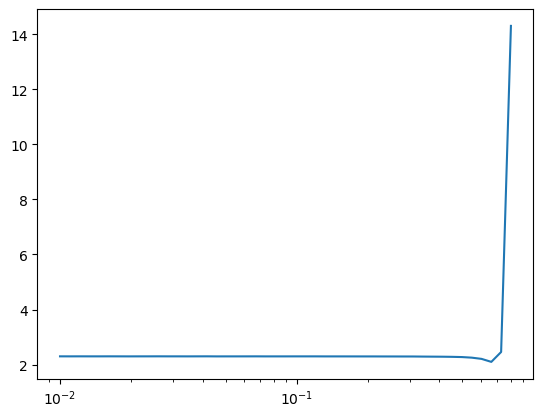

In [8]:
# Find a good learning rate using the LR Finder
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [9]:
# Setup metrics, activation stats, callbacks and learner
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.133,2.304,0,train
0.100,2.303,0,eval


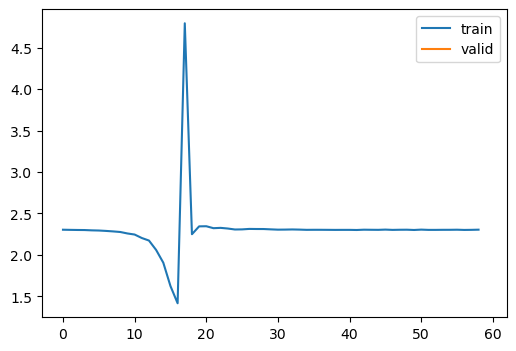

In [10]:
# Fit one epoch
learn.fit(1)

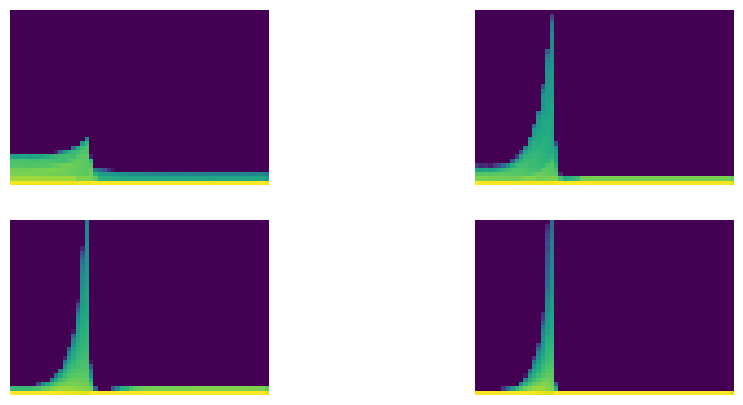

In [11]:
# Activation stats for the model's layers following one epoch of training
astats.color_dim();

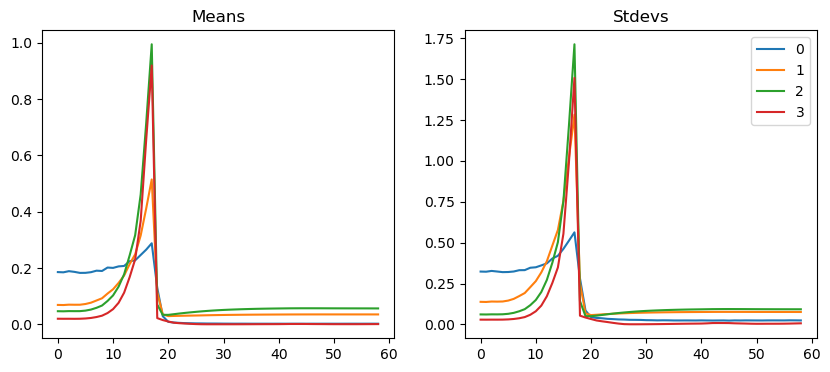

In [12]:
# Means and Standard Deviations of activations
astats.plot_stats();

### **Some Extra Functionality**  

The following functions allow us to clean and recover both GPU and system memory without having to restart the notebook kernel.

`clean_ipython_hist()` is designed to clean the history of commands in an active IPython session.

In [13]:
def clean_ipython_hist():
    # Copied mainly from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython() # Currently running IPython instance
    user_ns = ip.user_ns # Namespace (dictionary) where user variables are stored
    pc = ip.displayhook.prompt_count + 1 # Number of commands/cells executed in the current session 
    # Cycle through inputs in the namespace, and clear the stored input history
    # None ensures no error is raised if a key doesn't exist
    for n in range(1, pc): user_ns.pop('_i' + repr(n), None) 
    # Set the last 3 inputs in the session to empty to clear references
    user_ns.update(dict(_i='', _ii='', _iii=''))
    # hm is the history manager of any given session
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc # Clear parsed input history
    hm.input_hist_raw[:] = [''] * pc # Clear raw input history
    hm._i = hm._ii = hm._iii = hm._i00 = '' # Clear last few inputs from hm.

Next, `clean_tb()` is meant to free up resources and preventing memory leaks after an exception has occurred by clearing the last traceback's frames to free up memory.

In [14]:
def clean_tb():
    if hasattr(sys, 'last_traceback'): # Check for last_traceback attribute in the event of an unhandled exception
        # Remove references to local variables and free up memory
        traceback.clear_frames(sys.last_traceback) 
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type') # Remove last exception's type
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value') # Remove last exception's actual value

In [15]:
# Function to run memory cleaning ops
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## **Glorot / Xavier Initialization**

This type of initialization came from one of the early papers titled ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a) which attempted to address the issue of the poor performance of SGD using purely random initializations.

A simple way to understand the mechanics of initializations is to create a matrix (inputs) with random numbers and to carry out a series of matrix multiplications with another matrix (weights) containing random numbers. This basically simulates the creation of a 50 deep neural network.

The output will be `nan`, denoting extremely large numbers.

In [16]:
# randn() ensures mean 0 and variance 1
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[0:10, 0:10]

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

Given that the scale of our matrix was too large, we can experiment with decreasing the size of our weights.

This approach creates another problem. With weights being too small, the scale of our activations will go from 1 to 0.1, and after 50 or so layers, the end result is 0s (due to extremely small numbers).

In [17]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.01) # Decrease the weights
x[0:10, 0:10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

The scaling of our weight matrices needs to be just right so that the standard deviation of the activation remains 1 or close to 1, with the mean being 0 or close to 0. Glorot and Bengio used the scale $\frac{1}{\sqrt{n_{in}}}$, with $n_{in}$ being the number of inputs.

In [18]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:10,0:10]

tensor([[    -0.17,      5.50,      1.04,     -0.60,     -2.19,      3.94,     -7.50,      2.48,     -0.27,      3.17],
        [    -0.09,     -1.01,      0.08,      0.05,      0.46,     -0.64,      0.98,     -0.21,      0.45,     -0.91],
        [    -0.44,      0.23,     -0.14,     -0.19,      0.74,      0.64,      0.72,      0.22,      0.06,      0.72],
        [    -0.48,     -0.38,      0.73,      0.53,      0.37,     -0.14,     -0.27,      0.12,     -0.28,     -0.00],
        [     0.51,      0.78,     -0.59,     -0.53,     -0.97,      0.36,     -0.95,      0.47,      0.63,     -0.10],
        [     0.29,     -0.49,     -0.75,     -0.34,      0.34,     -0.28,      1.42,     -0.62,      0.34,     -0.60],
        [    -0.32,     -0.85,      0.41,      0.43,      0.19,     -0.88,      0.20,     -0.16,     -0.42,     -0.63],
        [     0.81,      2.07,     -0.31,     -0.54,     -1.16,      1.27,     -1.86,      0.13,     -0.22,      1.11],
        [    -1.24,     -4.28,      2.24

### **Derivation**

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since that was the requirement).

In [19]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.12), tensor(0.92))

Assuming that we choose weights for `a` which also have a mean of 0, the standard deviation of `y` can be computed easily. The matmul operation is repeated many times to offset the chance of ending up with erroneous values.

In [20]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()

mean / 100, sqr / 100

(-0.003219463638961315, 99.37359375)

The result is very close to the random matrix in the with 100 elements. This demonstrates that as long as the elements in `a` and the elements in `x` are independent, the mean stays close to 0 and the standard deviatin stays close to 1.

In [21]:
mean, sqr = 0., 0.
for i in range(100000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()

mean / 100000, sqr / 100000

(-0.00225837315553985, 1.003000174488075)

> Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence math.sqrt(100) being our magic number. If we scale the weights of the matrix and divide them by this math.sqrt(100), it will give us a y of scale 1, and repeating the product has many times as we want won't overflow or vanish.

Mathematically, that all seems fine. But the Xavier / Glorot Initialization **doesn't work when rectified linear units are added to the mix**.

## **Kaiming / He Initialization**

### **Derivation**

In [22]:
x = torch.randn(200, 100)
y = torch.randn(200)

x.shape, y.shape

(torch.Size([200, 100]), torch.Size([200]))

In [23]:
from math import sqrt

In [24]:
# Initialize random weights and biases
w1 = torch.randn(100, 50) / sqrt(100) # Sqrt 100 is specifically mentioned in the Glorot paper.
b1 = torch.zeros(50)
w2 = torch.randn(50, 1) / sqrt(50)
b2 = torch.zeros(1)

In [25]:
# Function to create a simple linear model
def lin(x, w, b): return x @ w + b

In [26]:
# Layer 1 of the model's forward pass
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.00), tensor(0.99))

In [27]:
# Function to create ReLU layer
def relu(x): return x.clamp_min(0.)

# Running outputs of layer 1 through RelU
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.39), tensor(0.58))

During the forward pass, the outputs of the linear layer - having a mean close to 0 and standard deviation close to 1 - were passsed through a ReLU layer. This resulted in the mean and standard deviation which moved away from 0 and 1 quite measurably.

When we do the same for our simulated neural network i.e. pass it through a ReLU layer while using the Glorot / Xavier initialization, the result is a matrix full of zeros or extremely small numbers.

In [28]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * 0.1))
x[0:10, 0:10]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [ 

The fix for this problem came with the highly impactful paper titled "Delving Deep into Rectifiers: Surpassing Human-Level Performance". Here Kaiming He et al. showed that we should be using a scaling factor of $\sqrt{2 / n_{in}}$.

In [29]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * sqrt(2/100)))
x[0:10, 0:10]

tensor([[0.00, 0.44, 1.87, 0.00, 0.54, 0.00, 0.00, 0.00, 0.96, 0.00],
        [0.00, 0.56, 1.73, 0.00, 0.48, 0.00, 0.00, 0.00, 1.03, 0.00],
        [0.00, 0.30, 1.23, 0.00, 0.43, 0.00, 0.00, 0.00, 0.48, 0.00],
        [0.00, 0.68, 2.48, 0.00, 0.65, 0.00, 0.00, 0.00, 1.29, 0.00],
        [0.00, 0.17, 0.55, 0.00, 0.13, 0.00, 0.00, 0.00, 0.32, 0.00],
        [0.00, 0.45, 1.52, 0.00, 0.47, 0.00, 0.00, 0.00, 0.74, 0.00],
        [0.00, 0.33, 1.03, 0.00, 0.33, 0.00, 0.00, 0.00, 0.57, 0.00],
        [0.00, 0.42, 1.39, 0.00, 0.32, 0.00, 0.00, 0.00, 0.85, 0.00],
        [0.00, 0.30, 1.10, 0.00, 0.32, 0.00, 0.00, 0.00, 0.55, 0.00],
        [0.00, 0.29, 0.96, 0.00, 0.28, 0.00, 0.00, 0.00, 0.52, 0.00]])

This results in a lot more activations!

## **Applying An Initialization Function**

In [30]:
# Create model and print out all the modules
model = get_model()
# Print all modules regardless of their depth
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [32]:
# Applying PyTorch's Kaiming initialization
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [33]:
# Apply the function recursively to every module
model.apply(init_weights);

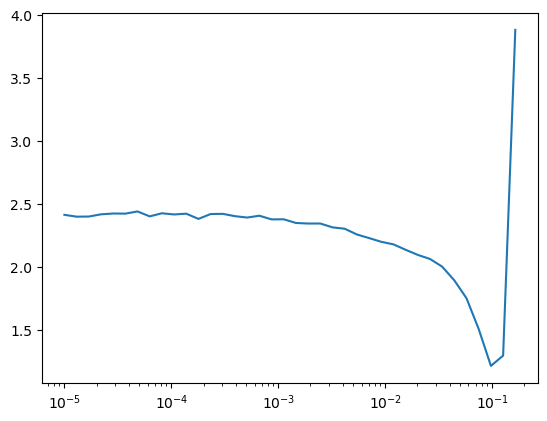

In [34]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

accuracy,loss,epoch,train
0.606,1.169,0,train
0.785,0.564,0,eval
0.824,0.473,1,train
0.829,0.462,1,eval
0.852,0.398,2,train
0.852,0.398,2,eval


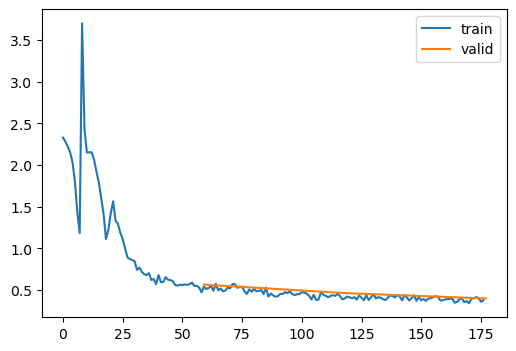

In [35]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

learn.fit(3)

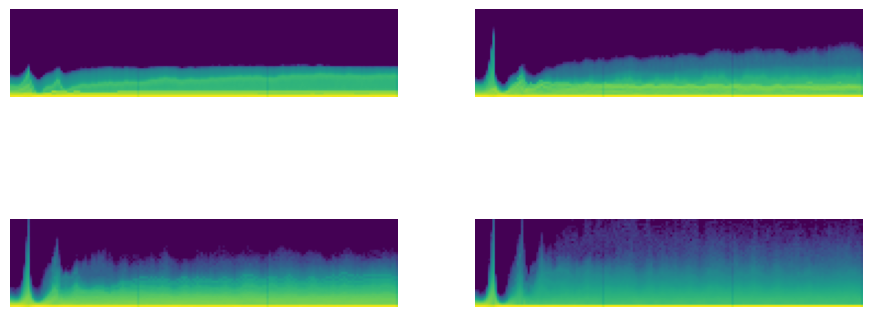

In [36]:
astats.color_dim()

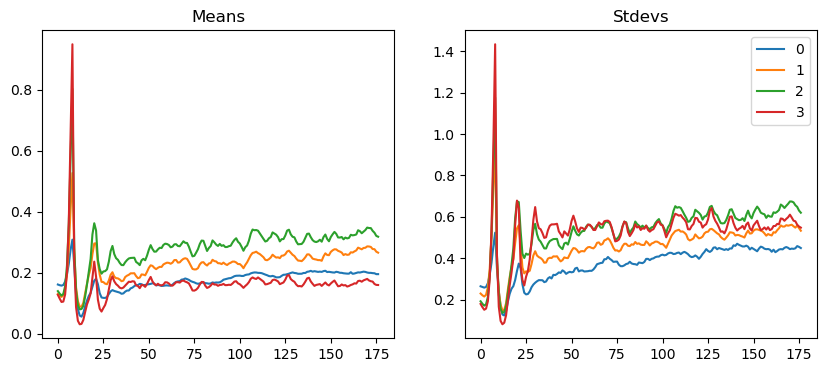

In [37]:
astats.plot_stats()

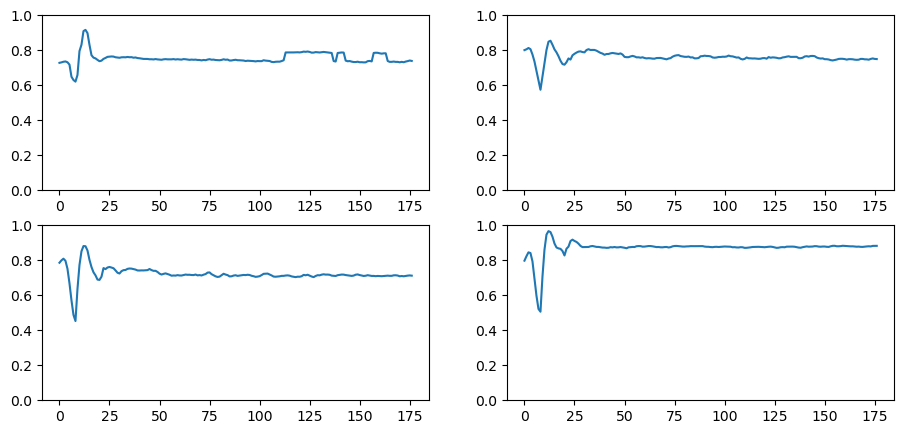

In [38]:
astats.dead_chart()

While the model's training run isn't ideal by any stretch, given the spikes in early steps, the plots show that activations per layer have vastly increased. But the issue of not having a mean of 0 and standard deviation of 1 remains!!

The primary reason for this is that we still haven't normalized our inputs.

## **Input Normalization**

Recall that the input mini batches did not have a mean and standard deviation of 0 and 1.

In [39]:
x_mean, x_std = xb.mean(), xb.std()
x_mean, x_std

(tensor(0.28), tensor(0.35))

We can create a callback to normalize our inputs to have to correct statistics. The inplace function will basically subtract each batch with its mean and divide by the standard deviation.

In [40]:
class BatchTransformCB(Callback): # Carry out any transformation on input batches
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [41]:
# Function to normalize inputs
def _norm(b): return (b[0] - x_mean) / x_std, b[1]

norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.510,1.511,0,train
0.759,0.634,0,eval
0.807,0.516,1,train
0.819,0.491,1,eval
0.842,0.425,2,train
0.841,0.429,2,eval


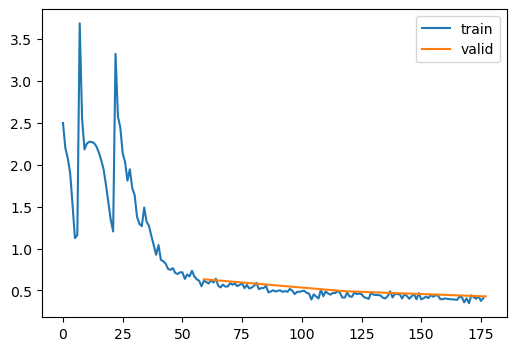

In [42]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm]) # Passing as an additional callback.
learn.fit(3)

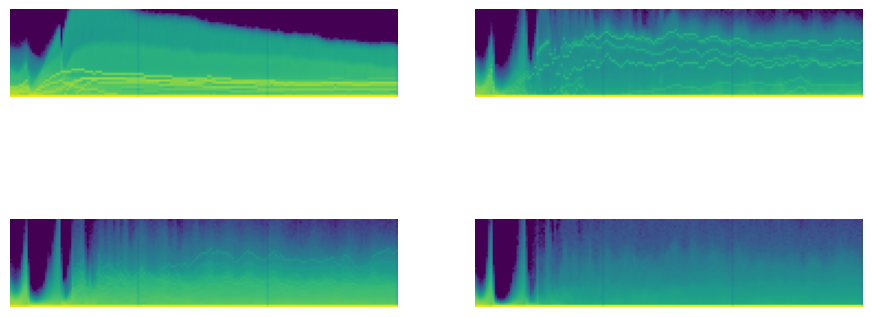

In [43]:
astats.color_dim()

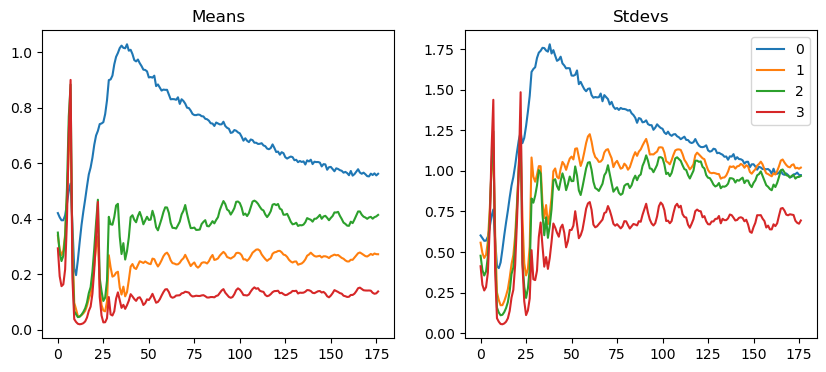

In [44]:
astats.plot_stats()

These outputs have certainly improved since our last run, with accuracy crossing the 81% mark. However, there is still randomness during the initial training steps, with means and standard deviations gyrating to a great degree. 

It is important to note that running our matrix multiplications, with an updated activation function while using normalized input batches through a `ReLU()` function guarantees that the outputs **will not have** any negative numbers, therefore the mean can never be zero.

This is also referred to as the [dying ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), where:

> the gradient is 0 whenever the unit is not active. This could lead to cases where a unit never activates as a gradient-based optimization algorithm will not adjust the weights of a unit that never activates initially. Further, like the vanishing gradients problem, we might expect learning to be slow when training ReL networks with constant 0 gradients.

By this logic, standard `ReLU()` will be fundamentally incompatible with what we are trying to achieve. 

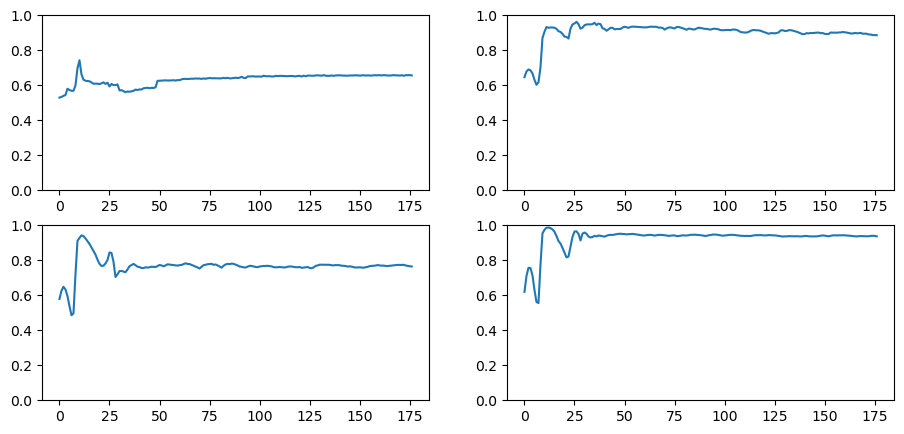

In [45]:
astats.dead_chart()

In [46]:
# Using the existing transformation function to carry out normalization in place.
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - x_mean) / x_std for o in b[xl]]

In [47]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb, yb = next(iter(dls.train))

In [48]:
# Verifying results
xb.mean(), xb.std()

(tensor(0.02), tensor(1.01))

## **Creating a Customized General ReLU**

Building on the previous section, we need to address the issue of the absence of negative outputs due to how `ReLU()` rectifies inputs.

This is where [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) can help. This is a modification to the original function which allows small negative values when the input is less than 0. So, we can create a function called `GeneralReLU` which implements Leaky ReLU while also carrying out a subtraction.

In [50]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub # Subtract value from the activations on top of leak factor
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [51]:
# Creating a plotting function to visualize leaky relu
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

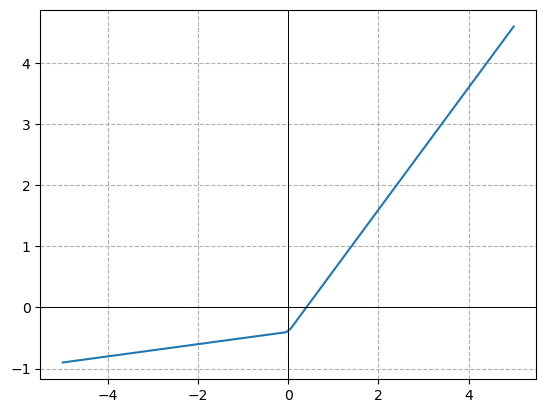

In [52]:
plot_func(GeneralRelu(leak=0.1, sub=0.4)) # This combo has shown promising results with this data and architecture

In [53]:
# Create a new convolution function where we can change the activation function
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [54]:
# Update get_model() to allow us to change activation functions
def get_model(act=nn.ReLU, nfs=None):
    # This allows us to easily change the number of filters per layer
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    # Pass in the layers and activations to the convolutional network
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

The next cell is a classic case of _it's the small things that matter most._

Alongside the above updates, we also need to alter the `init_weights()` function so that it implements Leaky ReLU. **This is also where alot of practitioners make mistakes**.

While passing custom ReLU functions to the initialization function, such as `General ReLU` being passed to `Kaiming Initialization`, we need to ensure that the custom ReLU is part of the inputs of the init. `kaiming_normal()` assumes that a _standard ReLU_ function is being passed.

This is where the argument `a` comes into view (which seems pretty oddly hidden away). The custom ReLU needs to be passed to this arg. 

In [56]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky) # pass to arg `a`    

In [57]:
# General ReLU activation function using partial to pass the parameters
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
# Updated activation stats to switch from relu to general relu
astats = ActivationStats(fc.risinstance(GeneralRelu))
# Put necessary callbacks into a list
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
# Initialize weights with leaky relu using a partial func
iw = partial(init_weights, leaky=0.1)

In [58]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.772,0.642,0,train
0.842,0.420,0,eval
0.868,0.362,1,train
0.859,0.374,1,eval
0.882,0.321,2,train
0.865,0.363,2,eval


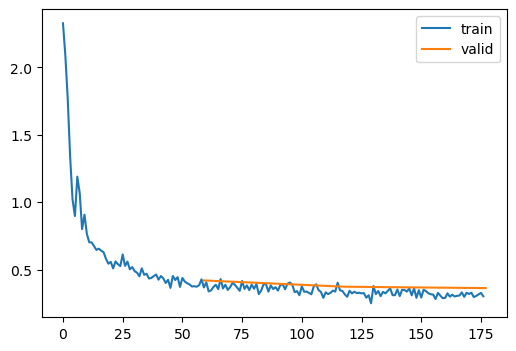

In [60]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Nice!!! We are now up to an accuracy of **86.5%**. Let's plot our stats, activations and dead neurons to see how much we have improved.

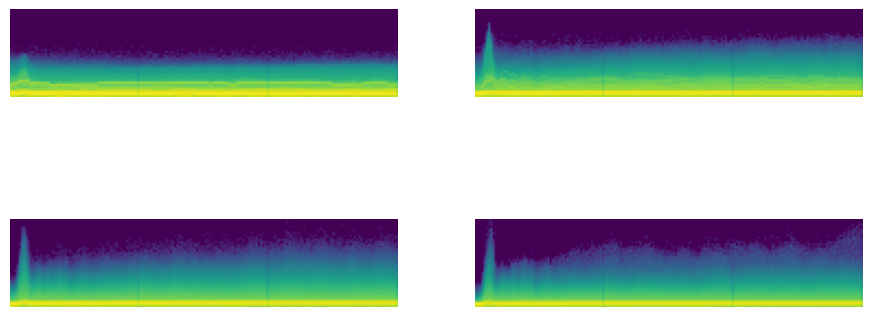

In [61]:
astats.color_dim()

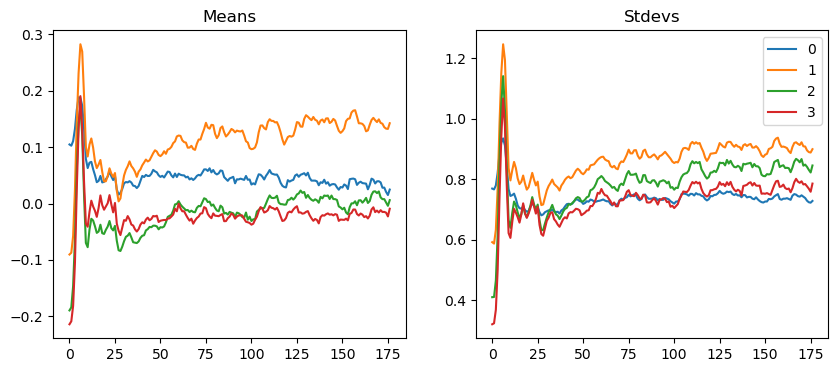

In [62]:
astats.plot_stats()

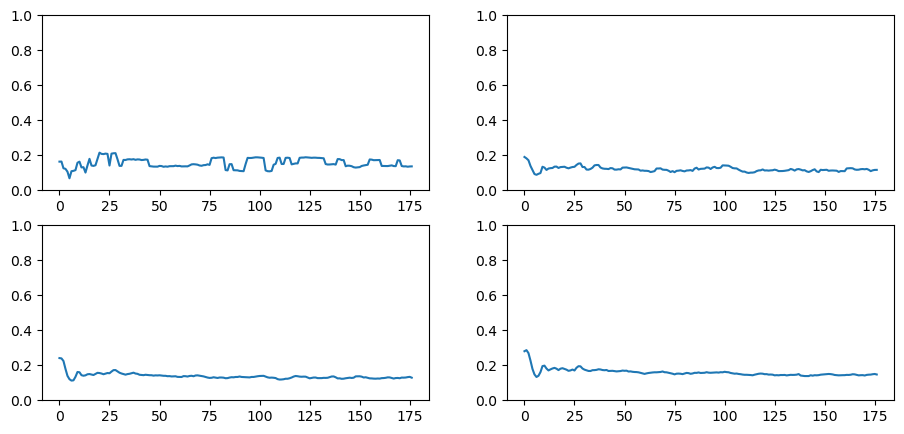

In [63]:
astats.dead_chart()

Both means and standard deviations have moved much closer to their ideal values of 0 and 1. The biggest change is apparent on the `dead_chart` where the number of failed activations has dropped considerably.

## **Testing LSUV**

The paper ["All You Need is a Good Init"](https://arxiv.org/pdf/1511.06422) and states that _Layer-wise Sequential Unit-Variance(LSUV)_ is:

> a simple method for weight initialization for deep net learning – is proposed. The method consists of the two steps. First, pre-initialize weights of each convolution or inner-product layer with orthonormal matrices.
> Second, proceed from the first to the final layer, normaliz-ing the variance of the output of each layer to be equal to one.

In [70]:
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    # Grab stats from each layer
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats) # Create a hook with the inplace function
    with torch.no_grad():
        # Run the model and check if standard dev. is not 1 and mean is not 0
        # Keep running till these stats are achieved.
        while model(xb) is not None and (abs(h.std-1))>1e-3 or abs(h.mean)>1e-3:
            m_in.bias -= h.mean # Subtract the mean from the bias
            m_in.weight.data /= h.std # Divide the weights with the std.dev.
    h.remove()

In [71]:
model = get_model(act_gr)
# Putting convs and relus in lists
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [72]:
# Demo: Put these in a list
for ms in zip(relus, convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [73]:
# Run the above, but pass the relus and convs through lsuv
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.647,0,train
0.835,0.451,0,eval
0.861,0.380,1,train
0.852,0.402,1,eval
0.875,0.338,2,train
0.858,0.379,2,eval


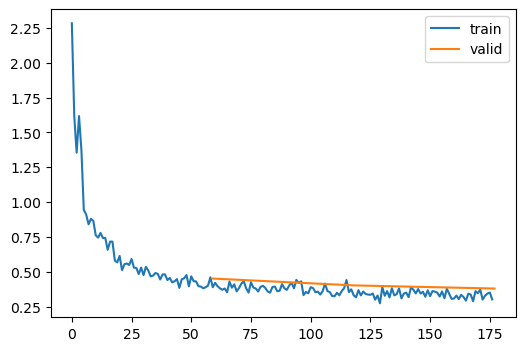

In [74]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

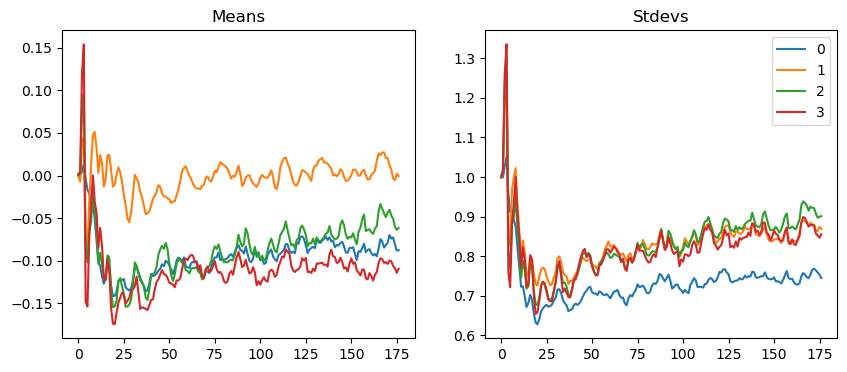

In [75]:
astats.plot_stats()

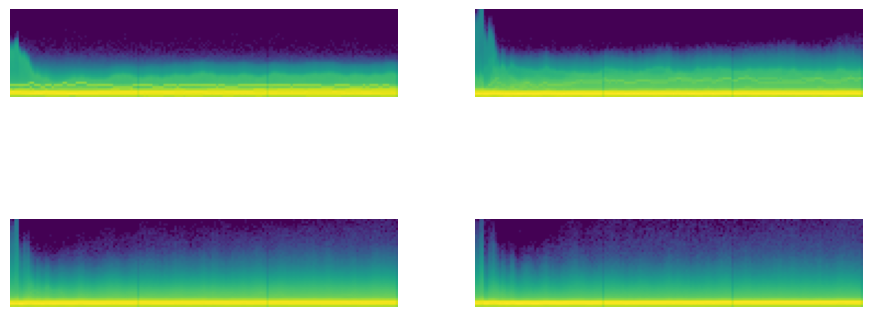

In [76]:
astats.color_dim()

## **Batch Normalization**

The really impactful paper ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167), states:

> Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as `internal covariate shift`, and address the problem by `normalizing layer inputs`.

The proposal is:

> Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.


### **LayerNorm**

This is a simpler technique and was [published](https://arxiv.org/abs/1607.06450) soon after the Batch Normalization paper. The abstract states:

> [Batch Normalization]] significantly reduces the training time in feed-forward neural networks. However, the effect of batch normalization is dependent on the mini-batch size and it is not obvious how to apply it to recurrent neural networks.

It goes on to say: 

>...we transpose batch normalization into layer normalization by computing the mean and variance used for normalization from all of the summed inputs to the neurons in a layer on a single training case. Like batch normalization, we also give each neuron its own adaptive bias and gain which are applied after the normalization but before the non-linearity.
>
>Unlike batch normalization, layer normalization performs exactly the same computation at training and test times. It is also straightforward to apply to recurrent neural networks by computing the normalization statistics separately at each time step. Layer normalization is very effective at stabilizing the hidden state dynamics in recurrent networks. Empirically, we show that layer normalization can substantially reduce the training time compared with previously published techniques. 

In [78]:
# Creating a LayerNorm module class.
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5): # Review default values as they may be too small for model training.
        super().__init__()
        self.eps = eps
        # Initialize by multiplying items by 1 and add 0s
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        # Layerwise forward function.
        m = x.mean((1, 2, 3), keepdim=True) #Batch x Channel x Height x Width (NCHW) so this becomes CHW
        v = x.var((1, 2, 3), keepdim=True)
        x = (x - m) / ((v + self.eps).sqrt()) # Normalize the layer and add a small number (epsilon) to the denominator.
        return x * self.mult + self.add 

Jeremy brought up an observation i.e. `self.mult` and `self.add` are learnable parameters and the LayerNorm function returns:

```
return x * self.mult + self.add
```
...which begins by normalizing the initial layer, obviating the need for an LSUV type function. But as it progresses through each layer in earlier batches, the model's "focus", for lack of better work, shifts to these two learnable parameters to create any distribution of outputs. JH thinks this is a very subtle effect.

In [110]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    # Bias is True in layers that don't use BatchNorm
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf)) # Append normalization layer with nf inputs
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [111]:
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    # Add layer norm to every layer except the last one
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

In [125]:
# Checking model parameters
model=get_model(act=act_gr, nfs=(1,8,16,32,64), norm=nn.BatchNorm2d)
[o.shape for o in model.parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([8]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([32, 16, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([64, 32, 3, 3]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([10, 64, 3, 3]),
 torch.Size([10])]

In [122]:
next(iter(model.modules()))

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

accuracy,loss,epoch,train
0.782,0.603,0,train
0.848,0.422,0,eval
0.864,0.371,1,train
0.860,0.379,1,eval
0.881,0.322,2,train
0.865,0.364,2,eval


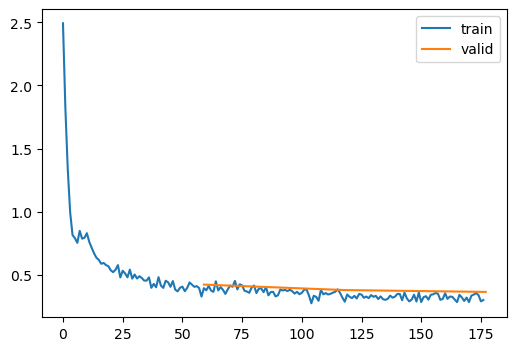

In [88]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

The model's training speed definitely improved and the performance is comparable to our last few runs.

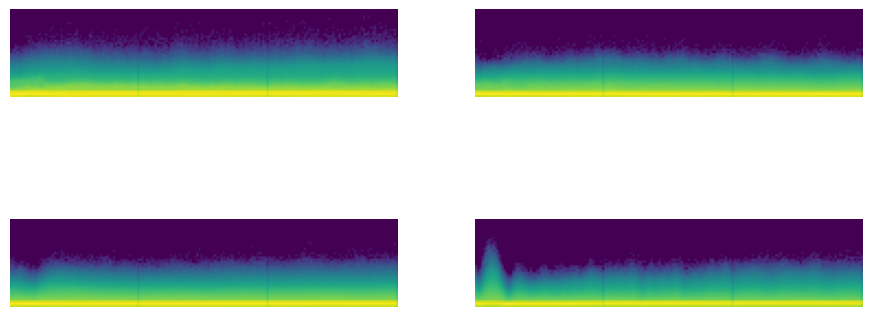

In [89]:
astats.color_dim()

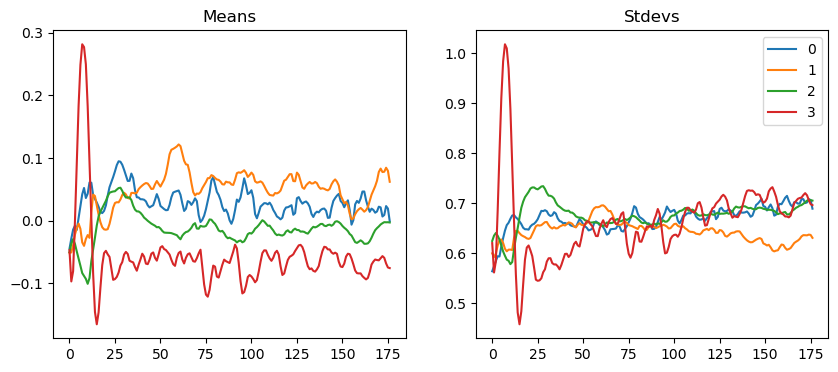

In [90]:
astats.plot_stats()

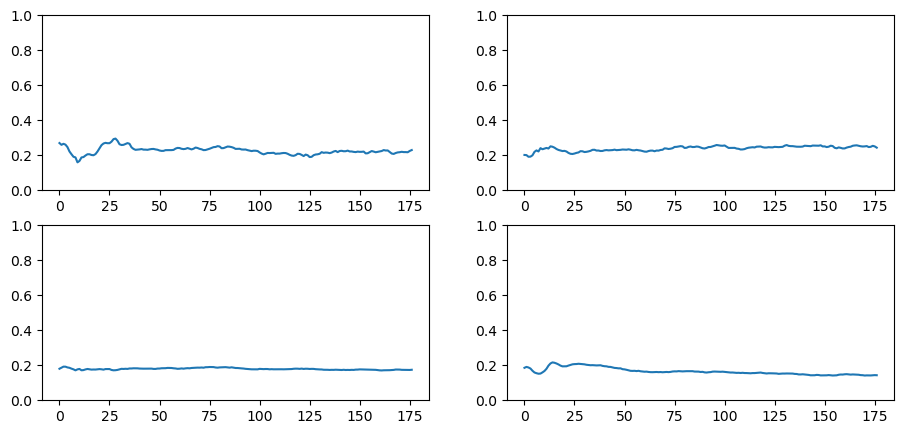

In [91]:
astats.dead_chart()

### **BatchNorm**

In [92]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # Pytorch BN momentum is the opposite of what we've worked with earlier in FastAI i.e. 0.1 would be 0.9 for the latter.
        self.mom, self.eps = mom, eps
        # The mults and adds are used as in layer norm, but we will be dealing with more values.
        # That means one value for every channel
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars',  torch.ones (1, nf, 1, 1)) # Initialize to 1s
        self.register_buffer('means', torch.zeros(1, nf, 1, 1)) # Initialize to 0s

    def update_stats(self, x):
        # Taking the mean and variance of the batch, height and width dims
        # Result is one mean per channel and one variance per channel
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var ((0, 2, 3), keepdim=True)
        # Taking the exponentially weighted moving average of m and v
        self.means.lerp_(m, self.mom) 
        self.vars.lerp_ (v, self.mom)
        return m, v

    def forward(self, x):
        if self.training: # update during training
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars # use saved means and variances during inference.
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds # multiply & add with vectors of mults and adds instead of single values.

accuracy,loss,epoch,train
0.770,0.650,0,train
0.837,0.453,0,eval
0.862,0.374,1,train
0.860,0.385,1,eval
0.880,0.327,2,train
0.863,0.369,2,eval


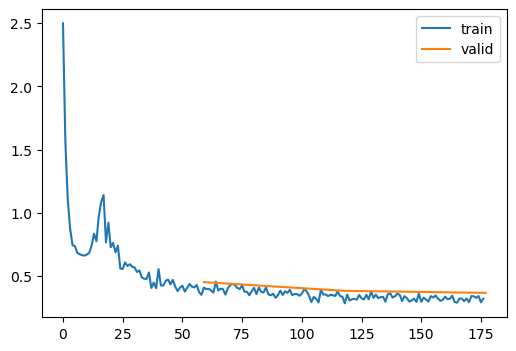

In [93]:
set_seed(42)
model = get_model(act_gr, norm=BatchNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

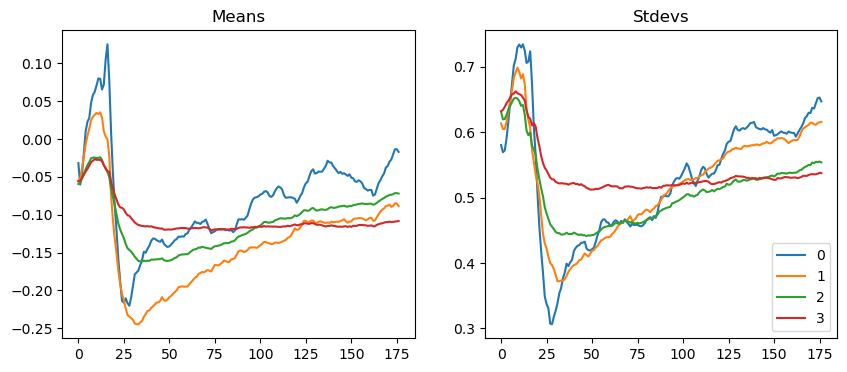

In [95]:
astats.plot_stats()

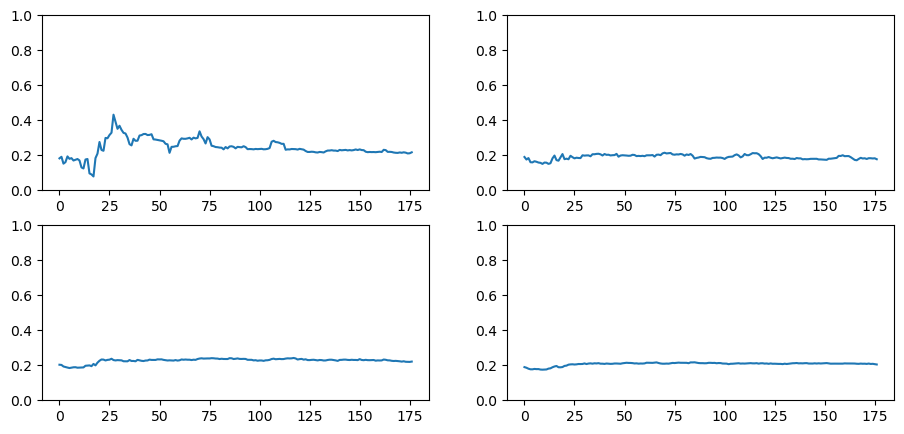

In [96]:
astats.dead_chart()

## **Pushing for 90% Accuracy**

In [102]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.836,0.449,0,train
0.866,0.362,0,eval
0.883,0.317,1,train
0.864,0.378,1,eval
0.896,0.281,2,train
0.885,0.316,2,eval


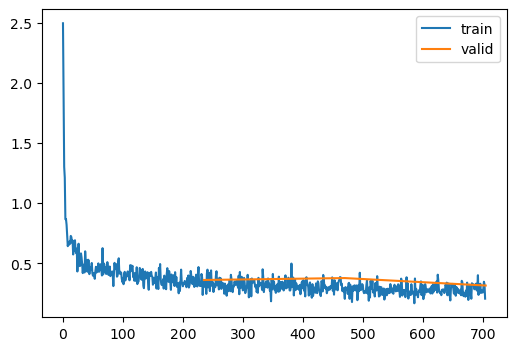

In [103]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

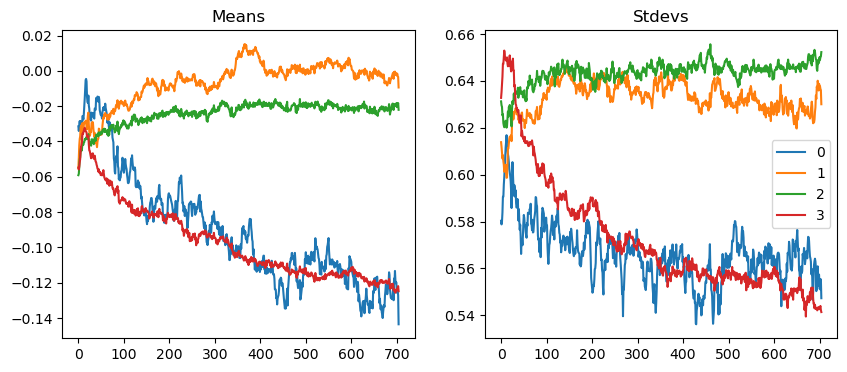

In [104]:
astats.plot_stats()

We will reduce the momemtum for 2 more epochs to push for 90% accuracy. This approach has been discussed in Leslie Smith's papers, which are linked in previous NBs.

accuracy,loss,epoch,train
0.917,0.226,0,train
0.893,0.286,0,eval
0.921,0.213,1,train
0.896,0.281,1,eval


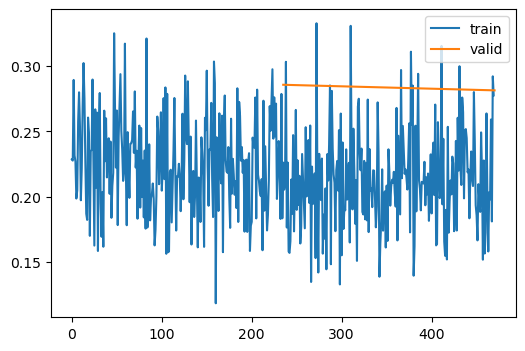

In [105]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## **Key Takeaway**

As with all things related to ML and DL, there was a considerable amount of hype surrounding Unit, Layer and Batch Normalizations. The trade-off for improved performance was that the models become considerably more complex and hard to manage.

In recent years, the community has started shifting its focus back to initializations.

> They (normalization layers) are helpful but are no silver bullets - JH.